In [7]:
# make baseline_model

In [1]:
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
os.getcwd()

'/home/makoto.hyodo/kaggle/HomeCredit/script'

In [13]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
# work day × income

def total_income(x):
    if x.WORK_YEAR < 3: return x.WORK_YEAR * x.AMT_INCOME_TOTAL
    elif x.WORK_YEAR < 5: return x.WORK_YEAR * 0.9 * x.AMT_INCOME_TOTAL
    elif x.WORK_YEAR < 10: return x.WORK_YEAR * 0.8 * x.AMT_INCOME_TOTAL
    elif x.WORK_YEAR >= 10: return x.WORK_YEAR * 0.7 * x.AMT_INCOME_TOTAL
    else: np.nan

def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    
    #(add) replace unknown
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    df['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
    df['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)

    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # make new val
    df['NEW_CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    df['NEW_income_credit_percentage'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_income_annuity_credit_percentage'] = (df['AMT_INCOME_TOTAL'] + df['AMT_ANNUITY']) / df['AMT_CREDIT'] 
    df['NEW_income_per_child'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_income_per_person'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_payment_rate'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    df['WORK_YEAR'] = (np.fabs(df['DAYS_EMPLOYED'])/ 365)
    df['NEW_ALL_INCOME'] = df.apply(lambda x: total_income(x),axis=1)
    del df['WORK_YEAR']
    
   # for function_name in ['min', 'max', 'sum', 'mean']:
   #     df['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
   #     df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    df['short_employment'] = (df['DAYS_EMPLOYED'] < -2000).astype(int)
    df['young_age'] = (df['DAYS_BIRTH'] < -14000).astype(int)
    
    
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    dropcolum=['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 
    'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
    df= df.drop(dropcolum,axis=1)
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
# 加えたいこと：work time × amnont income 
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    #(add) fillna = 0
    bureau['AMT_CREDIT_SUM'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0, inplace=True)
    bureau['CNT_CREDIT_PROLONG'].fillna(0, inplace=True)    
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    #bureau_agg = bureau_agg.join(active_agg, how='left')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    #bureau_agg = bureau_agg.join(closed_agg, how='left')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    #prev_agg = prev_agg.join(approved_agg, how='left')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    #prev_agg = prev_agg.join(refused_agg, how='left')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','min','std' ],
        'DBD': ['max', 'mean', 'sum','min','std'],
        'PAYMENT_PERC': [ 'max','mean',  'var','min','std'],
        'PAYMENT_DIFF': [ 'max','mean', 'var','min','std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','min','std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum','std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum','std']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    print(feature_importance_df)
    
    #return feature_importance_df
    #,train_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    #cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 200))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    print(best_features)
    best_features.sort_values(by="importance", ascending=False).to_csv('importance_' + submission_file_name, index= False)

In [14]:
def main(debug):
    num_rows = 30000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Make new val"):
        df['NEW_ALL_CREDIT_RATIO'] = df['NEW_ALL_INCOME'] / df['AMT_CREDIT']
        #df['NEW_INCOME_ACTIVE_CREDIT'] = df['AMT_INCOME_TOTAL'] / df['ACTIVE_AMT_CREDIT_SUM_SUM']
        df['NEW_TOTAL_DEFT_BALANCE'] = df['NEW_ALL_INCOME'] / (df['BURO_AMT_CREDIT_SUM_SUM'] + df['ACTIVE_AMT_CREDIT_SUM_SUM'] + df['CLOSED_AMT_CREDIT_SUM_SUM'])
        
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)
        print(feat_importance)
    return feat_importance

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 95)
Process bureau and bureau_balance - done in 15s
Previous applications df shape: (338857, 219)
Process previous_applications - done in 16s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 36)
Process installments payments - done in 29s
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 13s
Make new val - done in 1s
Starting LightGBM. Train shape: (307507, 731), test shape: (48744, 731)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858937	valid_1's auc: 0.792006
[2000]	training's auc: 0.900715	valid_1's auc: 0.793104
Early stopping, best iteration is:
[1805]	training's auc: 0.893832	valid_1's auc: 0.793174
Fold  1 AUC : 0.793174
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.85899	valid_1's auc: 0.7888
[2000]	training's auc: 0.900171	v

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:349: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                        feature  importance  fold
0                                   AMT_ANNUITY         525     1
1                                    AMT_CREDIT         268     1
2                               AMT_GOODS_PRICE         256     1
3                              AMT_INCOME_TOTAL         167     1
4                     AMT_REQ_CREDIT_BUREAU_DAY          24     1
5                    AMT_REQ_CREDIT_BUREAU_HOUR           0     1
6                     AMT_REQ_CREDIT_BUREAU_MON          13     1
7                     AMT_REQ_CREDIT_BUREAU_QRT          64     1
8                    AMT_REQ_CREDIT_BUREAU_WEEK          21     1
9                    AMT_REQ_CREDIT_BUREAU_YEAR          55     1
10                               APARTMENTS_AVG          66     1
11                              APARTMENTS_MEDI          60     1
12                              APARTMENTS_MODE          73     1
13                             BASEMENTAREA_AVG          36     1
14        

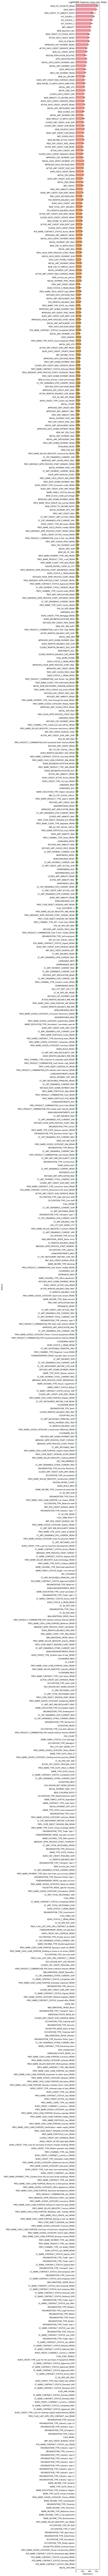

In [16]:
#if __name__ == "__main__":
submission_file_name = "submission_kernel_0805.csv"
#with timer("Full model run"):
main(debug = False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 95)
Process bureau and bureau_balance - done in 15s
Previous applications df shape: (338857, 219)
Process previous_applications - done in 16s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 36)
Process installments payments - done in 30s
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 13s
Starting LightGBM. Train shape: (307507, 726), test shape: (48744, 726)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858419	valid_1's auc: 0.79207
[2000]	training's auc: 0.899718	valid_1's auc: 0.793209
Early stopping, best iteration is:
[1808]	training's auc: 0.892956	valid_1's auc: 0.793425
Fold  1 AUC : 0.793425
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858438	valid_1's auc: 0.788717
Early stopping, best iteration is:
[1727]	training's auc:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                        feature  importance  fold
0                                   AMT_ANNUITY         523     1
1                                    AMT_CREDIT         256     1
2                               AMT_GOODS_PRICE         248     1
3                              AMT_INCOME_TOTAL         175     1
4                     AMT_REQ_CREDIT_BUREAU_DAY          25     1
5                    AMT_REQ_CREDIT_BUREAU_HOUR           0     1
6                     AMT_REQ_CREDIT_BUREAU_MON          19     1
7                     AMT_REQ_CREDIT_BUREAU_QRT          51     1
8                    AMT_REQ_CREDIT_BUREAU_WEEK          22     1
9                    AMT_REQ_CREDIT_BUREAU_YEAR          45     1
10                               APARTMENTS_AVG          69     1
11                              APARTMENTS_MEDI          42     1
12                              APARTMENTS_MODE          62     1
13                             BASEMENTAREA_AVG          46     1
14        

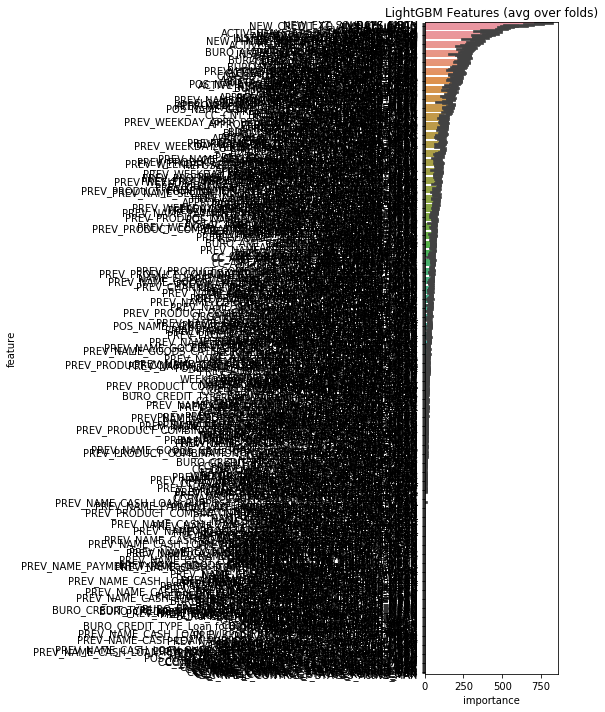

In [12]:
# Baseline
#if __name__ == "__main__":
submission_file_name = "submission_kernel_0805.csv"
#with timer("Full model run"):
main(debug = True)

In [6]:
train_df

NameError: name 'train_df' is not defined

In [ ]:
import os
os.chdir('/home/makoto.hyodo/')

In [25]:
%%bash
sh kaggle_submit_fix.sh HomeCredit script submission_kernel02.csv home-credit-default-risk baseline_0717

Successfully submitted to Home Credit Default Risk

: not found
